In [1]:
import warnings
warnings.filterwarnings('ignore')

from datasets import load_dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, Dense, Dropout, Bidirectional, LSTM, GRU, Input,LayerNormalization, 
                                        GlobalMaxPooling1D, Conv1D, MaxPooling1D, Concatenate)
from tensorflow.keras.optimizers import Adam

import torch

## 1. Load Dataset

In [2]:
dataset = load_dataset('uit-nlp/vietnamese_students_feedback')
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 11426
    })
    validation: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 1583
    })
    test: Dataset({
        features: ['sentence', 'sentiment', 'topic'],
        num_rows: 3166
    })
})

In [3]:
#Chuyển dataset thành dataframe
train_df = dataset['train'].to_pandas()
print('Train:', train_df.shape)
val_df = dataset['validation'].to_pandas()
print('Val: ', val_df.shape)
test_df = dataset['test'].to_pandas()
print('Test: ', test_df.shape)

#Gộp các df lại thành 1 df tên sentiment_data
sentiment_data = pd.concat([train_df, val_df, test_df], ignore_index = True)

#Xáo trộn thứ tự các dòng dataframe tránh việc mô hình học theo thứ tự dữ liệu, dẫn đến hiện tượng overfitting(học thuộc)
sentiment_data = sentiment_data.sample(frac = 1).reset_index(drop = True)
print('Sentiment data:', sentiment_data.shape)

#Đổi tên cột
sentiment_data = sentiment_data.rename(columns={'sentence' : 'comment','sentiment' : 'label'})
sentiment_data.head()

Train: (11426, 3)
Val:  (1583, 3)
Test:  (3166, 3)
Sentiment data: (16175, 3)


,comment,label,topic
0,nhằm giảm thời lượng giảng dạy cũng như sự thú...,0,3
1,chương trình dạy không đem nhiều lợi ích .,0,0
2,giảng viên đứng lớp sử dụng giờ trên lớp không...,0,0
3,"thầy rất nhiệt tình , giảng dễ hiểu .",2,0
4,"thầy vui tính , giảng bài dễ hiểu .",2,0


## 2. Data preprocessing

### 2.1 Duplicated

In [4]:
# Đếm số hàng trùng lặp và xóa
print('Số dữ liệu bị lặp: ', sentiment_data['comment'].duplicated().sum())
sentiment_data = sentiment_data.drop_duplicates('comment')

# Kiểm tra lại sau khi xóa
print('Số dữ liệu bị lặp sau khi xóa: ', sentiment_data['comment'].duplicated().sum())

sentiment_data = sentiment_data.reset_index(drop = True)
sentiment_data.shape

Số dữ liệu bị lặp:  1
Số dữ liệu bị lặp sau khi xóa:  0


(16174, 3)

### 2.2 Missing

In [5]:
# Kiểm tra giá trị missing
sentiment_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16174 entries, 0 to 16173
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  16174 non-null  object
 1   label    16174 non-null  int64 
 2   topic    16174 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 379.2+ KB


### 2.3 Over-sampling

In [6]:
def visualization_labels(sentiment_data):
    #Khảo sát
    label_counts = sentiment_data['label'].value_counts().sort_index()
    
    print('BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ:', sentiment_data.shape)
    print('CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:\n ', label_counts)
    
    #Trực quan hóa
    plt.figsize = (9,9)
    
    labels = ['Tiêu cực', 'Trung lập', 'Tích cực']
    mycolors = ['#009299', '#7ed957', '#00b980']
    plt.pie(label_counts, labels = labels, autopct = '%1.1f%%', startangle = 90, colors = mycolors)
    plt.title('Tỉ lệ số nhãn trong đánh giá')

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (16174, 3)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7439
1     698
2    8037
Name: count, dtype: int64


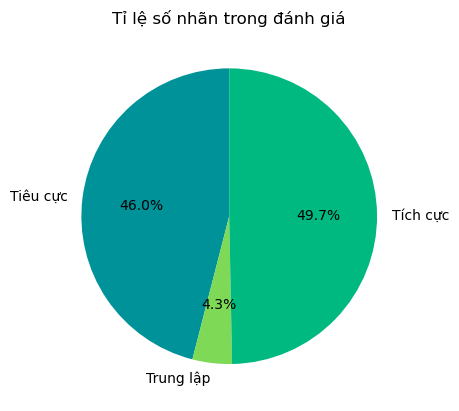

In [7]:
visualization_labels(sentiment_data)

In [8]:
from sklearn.utils import resample

train_comments = sentiment_data['comment'].values
# print(train_comments)

train_labels = sentiment_data['label'].values
# print(train_labels)

# Tìm chỉ số các câu trung lập(label=1)
neutral_indices = np.where(train_labels == 1)[0]

oversample_size = len(train_labels[train_labels ==0]) - len(neutral_indices)

oversampled_neutral_indices = resample(neutral_indices,
                                       replace = True,
                                       n_samples = oversample_size,
                                       random_state = 42)
oversampled_neutral_comments = train_comments[oversampled_neutral_indices]

train_comments_oversampled = np.concatenate([train_comments,oversampled_neutral_comments], axis = 0)
train_labels_oversampled = np.concatenate([train_labels, np.array([1]*oversample_size)], axis = 0)

In [9]:
sentiment_data_oversampled = pd.DataFrame({
    'comment' : train_comments_oversampled,
    'label' : train_labels_oversampled
})

sentiment_data = sentiment_data_oversampled.sample(frac=1, random_state=42).reset_index(drop=True)

BỘ DỮ LIỆU CÓ SỐ DÒNG VÀ CỘT LÀ: (22915, 2)
CÓ TẤT CẢ CÁC NHÃN VÀ SỐ LƯỢNG MỖI NHÃN LÀ:
  label
0    7439
1    7439
2    8037
Name: count, dtype: int64


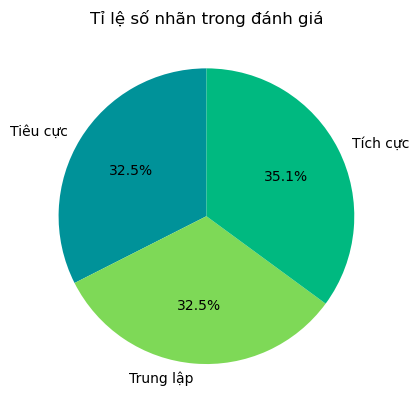

In [10]:
visualization_labels(sentiment_data)

### 2.4 Data normaliztion

In [11]:
import regex as re
import string
from underthesea import word_tokenize, text_normalize

#CHUẨN HÓA DỮ LIỆU
#Sử dụng hàm nhận diện icon 
emoji_pattern = re.compile("["
                u"\U0001F600-\U0001F64F" 
                u"\U0001F300-\U0001F5FF" 
                u"\U0001F680-\U0001F6FF" 
                u"\U0001F1E0-\U0001F1FF"
                u"\U00002702-\U000027B0" 
                u"\U000024C2-\U0001F251"
                u"\U0001f926-\U0001f937"
                u'\U00010000-\U0010ffff'
                u"\u200d"
                u"\u2640-\u2642"
                u"\u2600-\u2B55"
                u"\u23cf"
                u"\u23e9"
                u"\u231a"
                u"\u3030"
                u"\ufe0f"
    "]+", flags=re.UNICODE)

def clean_text(text):
    
    text=text.lower()  #chuyển toàn bộ text về chữ thường 
    text=re.sub(emoji_pattern," ",text)    #loại bỏ icon
    text = re.sub(r'([a-z]+?)\1+',r'\1', text)  #loại bỏ các ký chữ lặp trong từ(aaaaabbbb--> ab)


    #Đảm bảo khoảng trắng trước và sau giữa các dấu câu --> se , ti
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)

    #Xóa bớt các dấu câu lặp lại --> !!!!->!
    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)

    #Loại bỏ các dấu câu hoặc khoảng trắng ở đâu và cuối câu
    text=text.strip()
    while text.endswith(tuple(string.punctuation+string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation+string.whitespace)):
        text = text[1:]

    #Loại bỏ tất cả các dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Loại bỏ các khoảng trắng dư thừa trong câu
    text = re.sub(r"\s+", " ", text)

    #Tách từ 
    text = text_normalize(text)
    text = word_tokenize(text, format="text")

    return text

In [12]:
print('Câu gốc: ', sentiment_data['comment'][6])
print('Chuẩn hóa: ', clean_text(sentiment_data['comment'][6]))

Câu gốc:  ứng dụng của môn học đó giúp gì cho sinh viên .
Chuẩn hóa:  ứng_dụng của môn_học đó giúp gì cho sinh_viên


In [13]:
sentiment_data['corpus'] = sentiment_data['comment'].map(lambda text: clean_text(text))                                                     
sentiment_data.head(20)

,comment,label,corpus
0,em không hiểu và thầy giải thích em cũng không...,0,em không hiểu và thầy giải_thích em cũng không...
1,cần thay đổi giáo trình cho phù hợp với kiến t...,0,cần thay_đổi giáo_trình cho phù_hợp với kiến_t...
2,giảng viên .,1,giảng_viên
3,"điểm danh , làm bài kiểm tra thường xuyên tron...",1,điểm danh làm bài kiểm_tra thường_xuyên trong ...
4,nhiệt tình và bài giảng sinh động .,2,nhiệt_tình và bài giảng sinh_động
5,thầy nói hơi nhỏ .,0,thầy nói hơi nhỏ
6,ứng dụng của môn học đó giúp gì cho sinh viên .,1,ứng_dụng của môn_học đó giúp gì cho sinh_viên
7,đây là những ví dụ nhập môn mà các em học sinh...,1,đây là những ví_dụ nhập_môn mà các em học_sinh...
8,listening .,1,listening
9,"thưa , cô luôn đưa ra những bài tập mang tính ...",2,thưa cô luôn đưa ra những bài_tập mang tính th...


### 2.5 Visualization

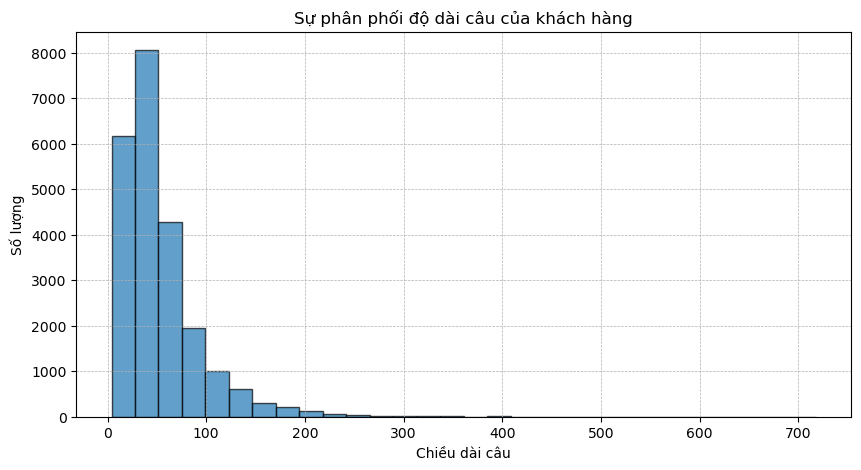

In [14]:
#Xem chiều dài của comment tập trung chủ yếu bao nhiêu 
lengths = sentiment_data['comment'].apply(len)

#Biểu đồ histogram
plt.figure(figsize=(10,5))
plt.hist(lengths, edgecolor='k', bins=30, alpha=0.7)#bin=30 chia khoảng giá trị thành 30 nhóm 
plt.title('Sự phân phối độ dài câu của khách hàng')
plt.xlabel('Chiều dài câu')
plt.ylabel('Số lượng')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

Số tất cả từ: 16001
Số từ xuất hiện nhiều nhất top 15: [('em cảm_ơn', 34), ('không có ý_kiến gì', 28), ('không có ý_kiến', 28), ('không', 26), ('cảm_ơn thầy', 22), ('em cám_ơn', 22), ('không có điều gì', 20), ('thầy không dạy em môn này', 20), ('khả_năng truyền_tải kiến_thức', 20), ('cảm_ơn', 20), ('cách dạy của thầy', 19), ('hầu_như không có vấn_đề gì không hài_lòng', 19), ('không có ạ', 19), ('không có', 19), ('học đều_đặn', 19)]


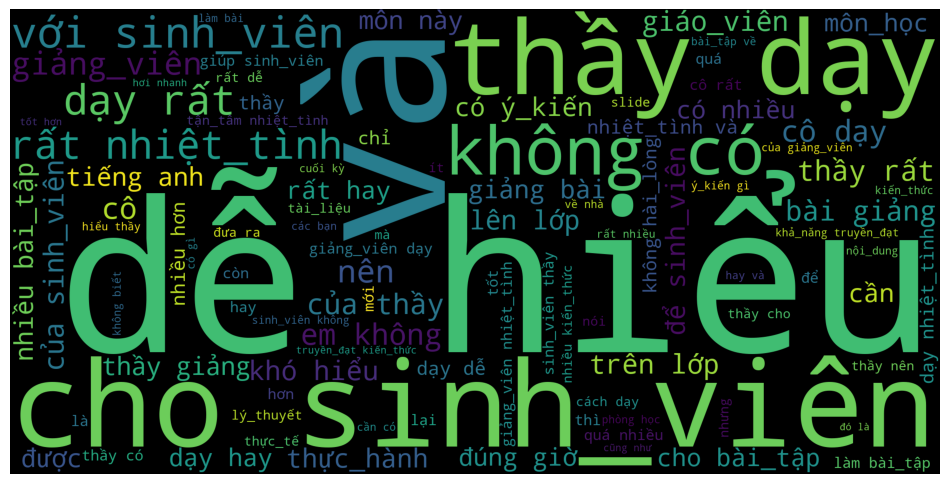

In [15]:
import nltk
import wordcloud

#XEM TRẠNG THÁI BAN ĐẦU CHƯA DỰ ĐOÁN CỦA BỘ DỮ LIỆU 

#Lọc bỏ các khoảng trắng chỉ lấy chữ
all_words= [token for token in sentiment_data['corpus'].tolist() if token and token!=' ']
 
corpus=' '.join(all_words)   #Nối lại thành chuỗi
all_words = nltk.FreqDist(all_words)  #Tính tần suất xuất hiện của từng từ trong danh sách 

print('Số tất cả từ: {}'.format(len(all_words)))
print('Số từ xuất hiện nhiều nhất top 15: {}'.format(all_words.most_common(15)))


plt.figure(figsize=(12,8))
word_cloud = wordcloud.WordCloud(max_words=100,background_color ="black",
                               width=2000,height=1000,mode="RGB").generate(corpus)

plt.axis("off")  #tắt hiển thị các trục 
plt.imshow(word_cloud)


In [16]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="weighted"
    )
    return {
        "accuracy": round(model_accuracy,2),
        "precision": round(model_precision,2),
        "recall": round(model_recall,2),
        "f1": round(model_f1,2)
    }

In [17]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, name):
    print(f" Confusion Matrix: {name}")
    cm = sk_confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Tiêu cực", "Trung lập", "Tích cực"],
                yticklabels=["Tiêu cực", "Trung lập", "Tích cực"])
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


## 3. Machine Learning Model

### 3.1. Data Preparation

In [18]:
from sklearn.model_selection import train_test_split 

# Tách cột 'corpus' chứa văn bản đã chuẩn hóa làm input (X)
X = sentiment_data['corpus']

# Tách cột 'label' làm nhãn đầu ra (y), và đảm bảo kiểu dữ liệu là int
y = sentiment_data['label'].astype(int)  

# Chia dữ liệu thành tập train và test (tỷ lệ test = 20%), 
# random_state=42 để đảm bảo tái lập (reproducibility),
# stratify=y để giữ tỉ lệ phân bố nhãn trong cả train và test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 18332, Test: 4583


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer  

# Khởi tạo vectorizer với:
# - max_features=5000: chỉ giữ lại 5000 từ đặc trưng nhất (giảm chiều dữ liệu)
# - ngram_range=(1,2): dùng cả unigram (1 từ) và bigram (2 từ liên tiếp)
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

# Học và biến đổi dữ liệu train thành ma trận TF-IDF
X_train_tfidf = tfidf.fit_transform(X_train)

# Biến đổi dữ liệu test (dựa trên từ vựng đã học ở train)
X_test_tfidf = tfidf.transform(X_test)

### 3.2. Naive Bayes Model

In [20]:
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# Bắt đầu đếm thời gian huấn luyện
start_MNB = time.time()

# Khởi tạo và huấn luyện mô hình
classifier_MNB = MultinomialNB()
classifier_MNB.fit(X_train_tfidf, y_train)

# Kết thúc đếm thời gian huấn luyện
end_MNB = time.time()
time_MNB = end_MNB - start_MNB

print("Thời gian huấn luyện Multinomial Naive Bayes: ", str(time_MNB), " giây")

Thời gian huấn luyện Multinomial Naive Bayes:  0.0061495304107666016  giây


In [21]:
# Dự đoán nhãn cho tập test
y_pred_MNB = classifier_MNB.predict(X_test_tfidf)

# Đánh giá kết quả
MNB_resutls = calculate_results(y_test, y_pred_MNB)
print('Kết quả Multinomial Naive Bayes:',MNB_resutls)
print('\nReport:\n', classification_report(y_test, y_pred_MNB, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

Kết quả Multinomial Naive Bayes: {'accuracy': 87.19, 'precision': 0.88, 'recall': 0.87, 'f1': 0.87}

Report:
               precision    recall  f1-score   support

    Tiêu cực       0.81      0.93      0.86      1488
   Trung lập       0.93      0.83      0.88      1488
    Tích cực       0.89      0.86      0.87      1607

    accuracy                           0.87      4583
   macro avg       0.88      0.87      0.87      4583
weighted avg       0.88      0.87      0.87      4583



 Confusion Matrix: Naive Bayes Model


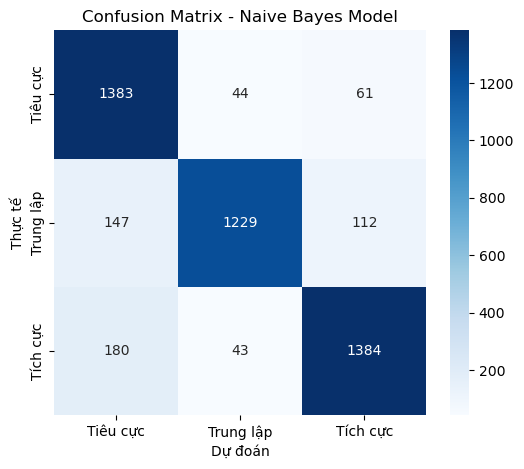

In [22]:
plot_confusion_matrix(y_test, y_pred_MNB,'Naive Bayes Model')

In [23]:
import joblib

joblib.dump(classifier_MNB, 'multinomial_naive_bayes_model.pkl')
print("Model saved successfully.")

Model saved successfully.


### 3.3. Logistic Regression Model

In [24]:
from sklearn.linear_model import LogisticRegression
# Kiểm tra thời gian huấn luyện
start_LR = time.time()

classifier_LR = LogisticRegression(max_iter=1000, random_state=0)
classifier_LR.fit(X_train_tfidf, y_train)

end_LR = time.time()
time_LR = end_LR - start_LR

print("Thời gian huấn luyện: ", str(time_LR), " giây")

Thời gian huấn luyện:  0.3099653720855713  giây


In [25]:
y_pred_LR = classifier_LR.predict(X_test_tfidf)

LR_resutls = calculate_results(y_test, y_pred_LR)

print('Kết quả Logistic Regression:', LR_resutls)
print('\nReport:\n', classification_report(y_test, y_pred_LR, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

Kết quả Logistic Regression: {'accuracy': 92.43, 'precision': 0.93, 'recall': 0.92, 'f1': 0.92}

Report:
               precision    recall  f1-score   support

    Tiêu cực       0.92      0.91      0.92      1488
   Trung lập       0.91      0.97      0.94      1488
    Tích cực       0.95      0.89      0.92      1607

    accuracy                           0.92      4583
   macro avg       0.92      0.93      0.92      4583
weighted avg       0.93      0.92      0.92      4583



 Confusion Matrix: Logistic Regression


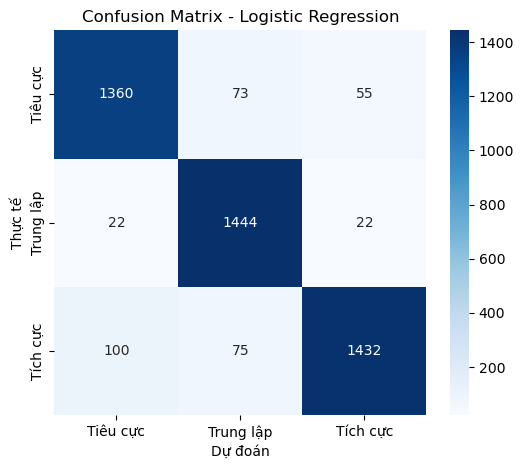

In [26]:
plot_confusion_matrix(y_test, y_pred_LR,'Logistic Regression')

In [27]:
joblib.dump(classifier_LR, 'logistic_regression_model.pkl')
print("Model saved successfully.")

Model saved successfully.


## 4. Deep Learning Model

### 4.1 Data preparation

In [28]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle

from sklearn.model_selection import train_test_split

input_pre = sentiment_data['corpus'].tolist()
label_with_accent = sentiment_data['label'].tolist()

label_tf = to_categorical(label_with_accent, num_classes = 3)
input_pre = [str(item) for item in input_pre] #Biến đổi nhãn (label) thành ma trận on-hot encoding.

#Phân tách dữ liệu văn bản đầu vào
tokenizer_data = Tokenizer(oov_token = '<00V>') # gán các từ chưa máy chưa học thì sẽ gán bằng mã '<00V>' để tránh lỗi khi xử lý 
tokenizer_data.fit_on_texts(input_pre)  # tách từ + đếm số lần xuất hiện tạo thành một từ điển 

#Chuyển đổi văn bản thành vector số
tokenizer_data_text = tokenizer_data.texts_to_sequences(input_pre)   #Biến đổi các văn bản trong input_pre (chuỗi) thành danh sách các chuỗi số,tương ứng từ được thay thế bằng chỉ số tương ứng trong từ điển
vec_data = pad_sequences(tokenizer_data_text, padding='post', maxlen = 45)  # Làm cho tất cả các chuỗi trong tokenized_data_text có cùng độ dài (ở đây là 45), nếu <45 thì thêm 0, ngược thì thì cắt bớt

#Lưu tokenizer(word_index) vào file nhằm mục đích tái sử dụng
pickle.dump(tokenizer_data, open('tokenizer_data.pkl','wb'))

# Chuyển vec_data thành numpy
vec_data = np.array(vec_data)  
print("Input data shape:", vec_data.shape)

# Lấy size từ vựng
data_vocab_size = len(tokenizer_data.word_index) + 1
print("Data vocab size:", data_vocab_size)

# Chia dữ liệu training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(vec_data, label_tf, test_size = 0.2, random_state = 42)
'''
    vec_data: là dữ liệu đầu vào sau khi đã sử lý với chiều dài là 45
    label_tf: là nhãn tương ứng với dữ liệu đầu vào đã được mã hóa ở dạng one-host encoding
    test_size=0.2 : lấy 20% cho tập validation và còn lại 80% cho tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 42)
'''
    X_train: là dữ liệu đầu vào
    y_train: là nhãn tương ứng với dữ liệu đầu vào
    test_size=0.1 : lấy 10% cho tập test từ tập training
    random_state=42: đảm bảo dữ liệu được lấy ngẫu nhiên 
'''
#training: chiếm 78%
# validation: chiếm 20%
# test: 8%


print("Training sample:", len(X_train))
print("Validation sample:", len(X_val))
print("Test sample:", len(X_test))

Input data shape: (22915, 45)
Data vocab size: 2817
Training sample: 16498
Validation sample: 4583
Test sample: 1834


### 4.2 Model CNN +Bi-LSTM

In [29]:
def model_cnn_bilstm():
    dropout_threshold = 0.4 # dùng để xác định tỉ lệ dropout trong mô hình, có nghĩa là trong mỗi lần huấn luyện thì sẽ có 40% cái connect sẽ bị ngắt kết nối ngẫu nhiên 
    input_dim = data_vocab_size # số từ vựng 
    output_dim = 32 # mỗi từ trong từ điển sẽ được ánh xạ với một vector là 32 chiều 
    input_length = 45
    initializer = tf.keras.initializers.GlorotNormal() # để tạo 1 trọng số ban đầu không phải là theo một cách ngẫu nhiên mà có tính toán cụ thể

    # Tầng đầu vào 
    input_layer = Input(shape=(input_length,)) # định ngĩa lớp đầu tiên của mô hình với một chiều dài cố định 

    # Tầng embedding --> nhằm mục đích chuyển đổi các chỉ số nguyên(các từ) thành vector nhúng
    feature = Embedding(input_dim=input_dim, #số tất cả các từ vựng 
                        output_dim=output_dim, # mỗi từ được biểu diễn 1 vector nhúng 32 chiều 
                        input_length=input_length,#độ dài chuỗi đầu vào 
                        embeddings_initializer=initializer)(input_layer)#khởi tạo các giá trị trong bảng nhúng 

    # CNN feature 
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(feature)
    '''
    --> Conv1D: tạo 1 lớp tích chập quét dữ liệu 1 chiều dọc 
    filters=32: có 32 bộ lọc 
    kernel_size=3: kích thước bộ lọc =3--> mỗi lần quét sẽ là 3 từ
    padding='same': đầu ra sẽ cùng kích thước đầu vào 
    activation='relu': tính toán dữ liệu đầu vào dựa theo hàm relu (>0 thì nhận ,<0 thì =0)
    '''
    cnn_feature = MaxPooling1D()(cnn_feature)#--> là giảm kích thước dữ liệu 
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)#-->giảm thiểu overfitting
    cnn_feature = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(cnn_feature)
    cnn_feature = MaxPooling1D()(cnn_feature)
    cnn_feature = LayerNormalization()(cnn_feature) #chuẩn hóa các đặc trưng trong một lớp, giúp giảm thiểu các vấn đề về độ lệch chuẩn của các giá trị và giúp quá trình huấn luyện trở nên ổn định hơn.
    cnn_feature = Dropout(dropout_threshold)(cnn_feature)

    # BiLSTM feature 
    bi_lstm_feature = Bidirectional(LSTM(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(feature)
    ''' merge_mode='concat': nghĩa là nếu lstm có 32 chiều thì mô hình hình sẽ tạo ra 64 chiều,32 chiều trước, 32 chiều sau '''
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)

    # BiGRU feature 
    bi_lstm_feature = Bidirectional(GRU(units=32, dropout=dropout_threshold, return_sequences=True,kernel_initializer=initializer), merge_mode='concat')(bi_lstm_feature)
    bi_lstm_feature = MaxPooling1D()(bi_lstm_feature)
    bi_lstm_feature = LayerNormalization()(bi_lstm_feature)

    # Combine features
    combine_feature = Concatenate()([cnn_feature, bi_lstm_feature]) # kết nối 2 feature lại thành 1 feature mới 
    combine_feature = GlobalMaxPooling1D()(combine_feature)
    combine_feature = LayerNormalization()(combine_feature)

    # Tầng 
    classifier = Dense(90, activation='relu')(combine_feature)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(70, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(50, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    
    classifier = Dense(30, activation='relu')(classifier)
    classifier = Dropout(0.2)(classifier)
    classifier = Dense(3, activation='softmax')(classifier)

    # Định nghĩa mô hình
    model = tf.keras.Model(inputs=input_layer, outputs=classifier)
    return model

In [30]:
model = model_cnn_bilstm()
adam = Adam(learning_rate=0.001)  # khởi tạo bộ tốc độ học với tốc độ 0.001
model.compile(optimizer = adam,loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 45)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 45, 32)            │          90,144 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 45, 32)            │           3,104 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d (MaxPooling1D)  │ (None, 22, 32)            │               0 │ conv1d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 22, 32)            │               0 │ max_pooling1d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 45, 64)            │          16,640 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 22, 32)            │           3,104 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_2               │ (None, 22, 64)            │               0 │ bidirectional[0][0]        │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_1               │ (None, 11, 32)            │               0 │ conv1d_1[0][0]             │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 22, 64)            │          18,816 │ max_pooling1d_2[0][0]      │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 11, 32)            │              64 │ max_pooling1d_1[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling1d_3               │ (None, 11, 64)            │               0 │ bidirectional_1[0][0]      │
│ (MaxPooling1D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 11, 32)            │               0 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 11, 64)            │             128 │ max_pooling1d_3[0][0]      │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 152,465 (595.57 KB)

 Trainable params: 152,465 (595.57 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_cnn_bilstm.keras', monitor='val_loss')
'''lưu trạng thái tốt nhất của mô hình trong quá trình huấn luyện 
monitor='val_loss': dựa trên giá trị val_loss nhỏ nhất
--> khi val_loss giảm hơn so với epochs trước đó thì sẽ được lưu vào mô hình 
'''
history = model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, callbacks=[callback_model])

Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.3763 - loss: 1.0983 - val_accuracy: 0.7639 - val_loss: 0.6095
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7520 - loss: 0.6441 - val_accuracy: 0.8726 - val_loss: 0.3802
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8571 - loss: 0.4247 - val_accuracy: 0.8898 - val_loss: 0.3058
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.8934 - loss: 0.3323 - val_accuracy: 0.9046 - val_loss: 0.2816
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9051 - loss: 0.2916 - val_accuracy: 0.9123 - val_loss: 0.2686
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9218 - loss: 0.2570 - val_accuracy: 0.9280 - val_loss: 0.2379
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9230 - loss: 0.2507 - val_accuracy: 0.9252 - val_loss: 0.2326
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9319 - loss: 0.2210 - val_acc

In [32]:
from tensorflow.keras.models import load_model

model.load_weights("model_cnn_bilstm.keras")

y_true_cnn_bilstm = y_test.argmax(axis = 1)

y_pred_probs_cnn_bilstm = model.predict(X_test)
y_pred_cnn_bilstm = y_pred_probs_cnn_bilstm.argmax(axis = 1)

cnn_bilstm_results = calculate_results(y_true_cnn_bilstm, y_pred_cnn_bilstm)

print('Kết quả CNN + Bi-LSTM:', cnn_bilstm_results)
print('\nReport:\n', classification_report(y_true_cnn_bilstm, y_pred_cnn_bilstm, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
Kết quả CNN + Bi-LSTM: {'accuracy': 93.18, 'precision': 0.93, 'recall': 0.93, 'f1': 0.93}

Report:
               precision    recall  f1-score   support

    Tiêu cực       0.93      0.91      0.92       605
   Trung lập       0.91      0.99      0.95       599
    Tích cực       0.96      0.90      0.93       630

    accuracy                           0.93      1834
   macro avg       0.93      0.93      0.93      1834
weighted avg       0.93      0.93      0.93      1834



 Confusion Matrix: CNN+Bi-LSTM


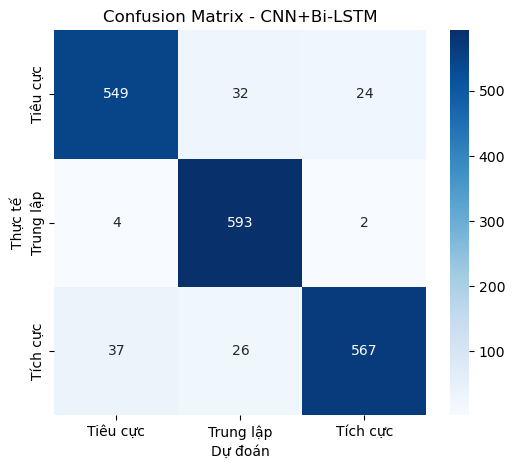

In [33]:
plot_confusion_matrix(y_true_cnn_bilstm, y_pred_cnn_bilstm,'CNN+Bi-LSTM')

### 4.3 Model FastText

#### 4.3.1 Model FastText+Keras

In [34]:
# Lấy dữ liệu đã chuẩn hóa từ cột 'corpus'
sentences = [sentence.split() for sentence in sentiment_data['corpus'].tolist()]
labels = sentiment_data['label'].tolist()


y = to_categorical(labels, num_classes=3)

X_train, X_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=42)

In [35]:
from gensim.models import FastText

# Khởi tạo mô hình FastText
fasttext_model = FastText(vector_size=100, window=5, min_count=1, workers=4)
fasttext_model.build_vocab(corpus_iterable=X_train)
fasttext_model.train(corpus_iterable=X_train, total_examples=len(X_train), epochs=20)

# Lưu mô hình
fasttext_model.save("fasttext_model.model")

In [36]:
# Hàm tính vector trung bình cho mỗi câu
def sentence_vector(sentence, model):
    vecs = [model.wv[word] for word in sentence if word in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# Chuyển toàn bộ tập thành vector
X_train_vec = np.array([sentence_vector(s, fasttext_model) for s in X_train])
X_test_vec = np.array([sentence_vector(s, fasttext_model) for s in X_test])

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

In [38]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_vec, y_train,
    validation_split=0.1,
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6617 - loss: 0.7605 - val_accuracy: 0.8037 - val_loss: 0.4995
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7871 - loss: 0.5450 - val_accuracy: 0.8239 - val_loss: 0.4391
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8118 - loss: 0.4827 - val_accuracy: 0.8511 - val_loss: 0.4117
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8357 - loss: 0.4255 - val_accuracy: 0.8571 - val_loss: 0.3806
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8447 - loss: 0.4140 - val_accuracy: 0.8626 - val_loss: 0.3565
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8536 - loss: 0.3879 - val_accuracy: 0.8719 - val_loss: 0.3314
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8651 - loss: 0.3661 - val_accuracy: 0.8855 - val_loss: 0.3215
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8739 - loss: 0.3439 - val_accuracy: 0.

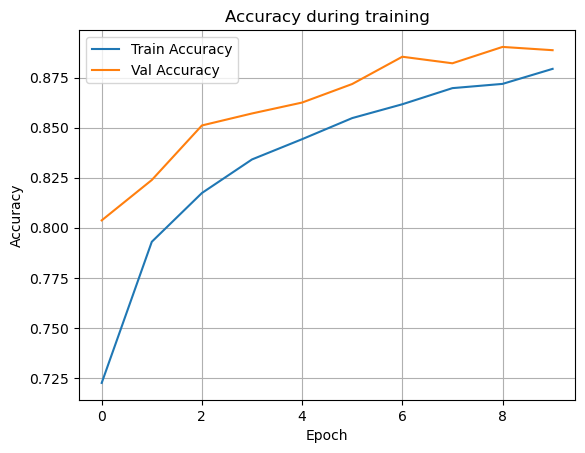

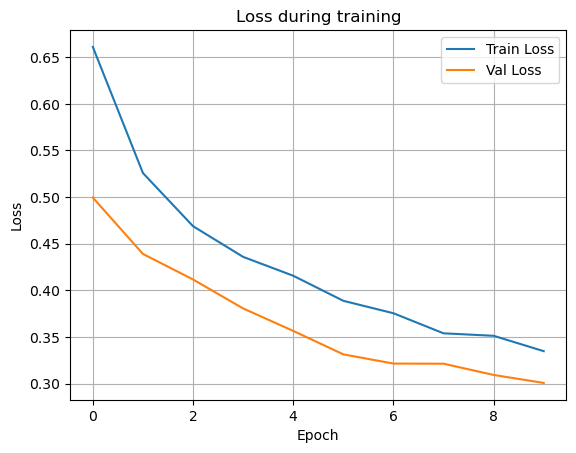

In [39]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy during training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss during training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [40]:

# Dự đoán xác suất (softmax) cho từng lớp
y_pred_probs = model.predict(X_test_vec)

y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

fasttext_results = calculate_results(y_true, y_pred)

print('Kết quả Fastext + Keras:', fasttext_results)
print('\nReport:\n', classification_report(y_true, y_pred, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))

# print("Đánh giá mô hình FastText + Keras:")
# print(classification_report(y_true, y_pred, digits=4))
# print("Accuracy:", accuracy_score(y_true, y_pred))

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Kết quả Fastext + Keras: {'accuracy': 89.02, 'precision': 0.89, 'recall': 0.89, 'f1': 0.89}

Report:
               precision    recall  f1-score   support

    Tiêu cực       0.89      0.85      0.87      1488
   Trung lập       0.84      0.96      0.90      1492
    Tích cực       0.94      0.86      0.90      1603

    accuracy                           0.89      4583
   macro avg       0.89      0.89      0.89      4583
weighted avg       0.89      0.89      0.89      4583



 Confusion Matrix: Fastext + Keras


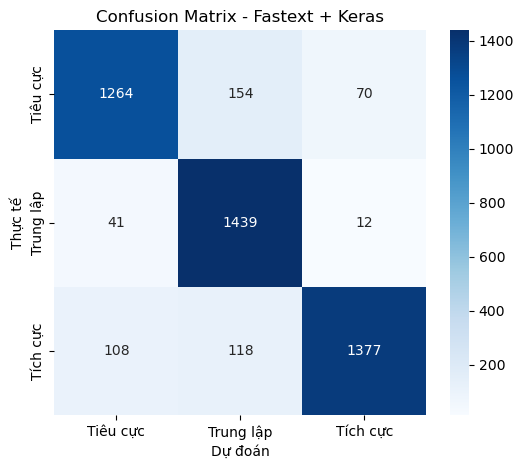

In [41]:
plot_confusion_matrix(y_true, y_pred,'Fastext + Keras')

#### 4.3.2 Model FastText+PhoBert

In [42]:
from gensim.models import KeyedVectors

# Load mô hình FastText 
fasttext_model = FastText.load("fasttext_model.model")

In [43]:
from transformers import AutoModel, AutoTokenizer
import torch.nn.functional as F
import torch

# Load PhoBERT
phobert_model = AutoModel.from_pretrained("vinai/phobert-base")
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert_model.eval()

# Hàm tạo vector từ PhoBERT
def get_phobert_vector(text):
    tokens = phobert_tokenizer(text, return_tensors='pt', truncation=True, max_length=60, padding='max_length')
    with torch.no_grad():
        output = phobert_model(**tokens)
        cls_embedding = output.last_hidden_state[:, 0, :]  
    return cls_embedding.squeeze(0)

# Hàm tạo vector từ FastText
def get_fasttext_vector(text):
    words = text.split()
    vecs = [fasttext_model.wv[word] for word in words if word in fasttext_model.wv]
    if vecs:
        return torch.tensor(np.mean(vecs, axis=0), dtype=torch.float32)
    else:
        return torch.zeros(fasttext_model.vector_size)

# Hàm kết hợp vector
def get_combined_vector(text):
    return torch.cat([get_phobert_vector(text), get_fasttext_vector(text)], dim=0)


In [44]:
from sklearn.model_selection import train_test_split
import numpy as np

input_pre = sentiment_data['corpus'].tolist()
label_with_accent = sentiment_data['label'].tolist()

# One-hot encoding cho nhãn
label_tf = to_categorical(label_with_accent, num_classes=3)

indices = np.arange(len(input_pre))

In [45]:
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_idx, test_idx = train_test_split(train_idx, test_size=0.1, random_state=42)


X_train_raw = [input_pre[i] for i in train_idx]
X_val_raw = [input_pre[i] for i in val_idx]
X_test_raw = [input_pre[i] for i in test_idx]


y_train = label_tf[train_idx]
y_val = label_tf[val_idx]
y_test = label_tf[test_idx]

In [46]:
import os
import torch

# Nếu đã có file thì load
if all(os.path.exists(f) for f in ['combined_train.pt', 'combined_val.pt', 'combined_test.pt']):
    combined_train = torch.load('combined_train.pt')
    combined_val = torch.load('combined_val.pt')
    combined_test = torch.load('combined_test.pt')
else:
# Nếu chưa có file thì tạo và lưu
    combined_train = [get_combined_vector(text) for text in X_train_raw]
    combined_val = [get_combined_vector(text) for text in X_val_raw]
    combined_test = [get_combined_vector(text) for text in X_test_raw]
    
    torch.save(combined_train, 'combined_train.pt')
    torch.save(combined_val, 'combined_val.pt')
    torch.save(combined_test, 'combined_test.pt')


X_train_tensor = torch.stack(combined_train)
X_val_tensor = torch.stack(combined_val)
X_test_tensor = torch.stack(combined_test)

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1))
y_val_tensor = torch.tensor(np.argmax(y_val, axis=1))
y_test_tensor = torch.tensor(np.argmax(y_test, axis=1))


In [47]:
import torch.nn as nn
class HybridClassifier(nn.Module):
    def __init__(self, input_dim=868, hidden_dim=512, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        return self.fc2(x)


In [48]:
from torch.utils.data import TensorDataset, DataLoader

y_train_tensor = y_train_tensor[:len(X_train_tensor)]
# Khởi tạo mô hình
model = HybridClassifier()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [49]:
epochs = 20  

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f}")
    
    # Đánh giá mô hình sau mỗi epoch
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor)
        preds = torch.argmax(outputs, dim=1)
        y_true = y_val_tensor.numpy()
        y_pred = preds.numpy()

        from sklearn.metrics import accuracy_score, f1_score
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')

        print(f"➡ Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

torch.save(model.state_dict(), "PhoBERT+FastText_model.pt")


Epoch 1/20 | Loss: 222.9480
➡ Accuracy: 0.8985 | F1-score: 0.8989
Epoch 2/20 | Loss: 135.7590
➡ Accuracy: 0.9337 | F1-score: 0.9336
Epoch 3/20 | Loss: 102.0661
➡ Accuracy: 0.9378 | F1-score: 0.9377
Epoch 4/20 | Loss: 80.7571
➡ Accuracy: 0.9516 | F1-score: 0.9514
Epoch 5/20 | Loss: 66.0863
➡ Accuracy: 0.9531 | F1-score: 0.9529
Epoch 6/20 | Loss: 57.1042
➡ Accuracy: 0.9605 | F1-score: 0.9604
Epoch 7/20 | Loss: 47.3176
➡ Accuracy: 0.9548 | F1-score: 0.9546
Epoch 8/20 | Loss: 41.8325
➡ Accuracy: 0.9577 | F1-score: 0.9575
Epoch 9/20 | Loss: 37.7835
➡ Accuracy: 0.9548 | F1-score: 0.9546
Epoch 10/20 | Loss: 32.9840
➡ Accuracy: 0.9609 | F1-score: 0.9608
Epoch 11/20 | Loss: 31.3740
➡ Accuracy: 0.9579 | F1-score: 0.9577
Epoch 12/20 | Loss: 27.7462
➡ Accuracy: 0.9588 | F1-score: 0.9586
Epoch 13/20 | Loss: 26.6364
➡ Accuracy: 0.9590 | F1-score: 0.9588
Epoch 14/20 | Loss: 23.5720
➡ Accuracy: 0.9592 | F1-score: 0.9590
Epoch 15/20 | Loss: 23.9628
➡ Accuracy: 0.9590 | F1-score: 0.9588
Epoch 16/20 | Lo

Kết quả Fastext + PhoBert: {'accuracy': 95.91, 'precision': 0.96, 'recall': 0.96, 'f1': 0.96}

Report:
               precision    recall  f1-score   support

    Tiêu cực       0.95      0.94      0.95       605
   Trung lập       0.97      1.00      0.99       599
    Tích cực       0.95      0.94      0.94       630

    accuracy                           0.96      1834
   macro avg       0.96      0.96      0.96      1834
weighted avg       0.96      0.96      0.96      1834

 Confusion Matrix: Fastext + PhoBert


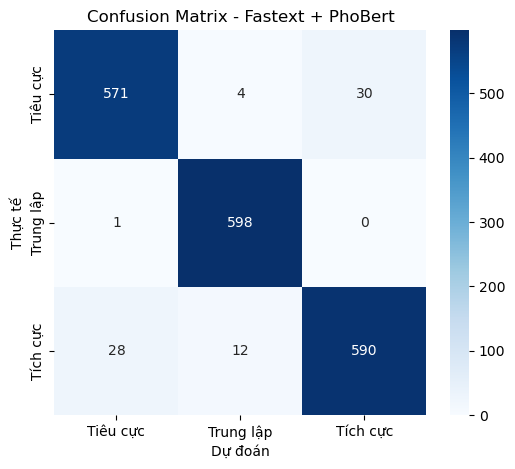

In [50]:
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    preds = torch.argmax(outputs, dim=1)

y_true = y_test_tensor.numpy()
y_pred = preds.numpy()

phobert_fasttex_result = calculate_results(y_true, y_pred)

print('Kết quả Fastext + PhoBert:', phobert_fasttex_result)
print('\nReport:\n', classification_report(y_true, y_pred, target_names=['Tiêu cực', 'Trung lập', 'Tích cực']))
plot_confusion_matrix(y_true, y_pred,'Fastext + PhoBert')

## 5. Compare Models


In [51]:
all_model_results = pd.DataFrame({'logistic_regression': LR_resutls,
                                  'multinomial_naive_bayes': MNB_resutls,
                                  'cnn_bilstm': cnn_bilstm_results,
                                  'fastext_keras':fasttext_results,
                                  'phobert_fasttext':phobert_fasttex_result
                                  
                                 })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
logistic_regression,92.43,0.93,0.92,0.92
multinomial_naive_bayes,87.19,0.88,0.87,0.87
cnn_bilstm,93.18,0.93,0.93,0.93
fastext_keras,89.02,0.89,0.89,0.89
phobert_fasttext,95.91,0.96,0.96,0.96


## 6. Test

In [52]:
# Hàm tiền xử lý đầu vào
def preprocess_raw_input(raw_input, tokenizer):

    input_text_pre=clean_text(raw_input)
    print("Text:", input_text_pre)

    # Chuyển đổi văn bản thành vector số 
    tokenized_data_text = tokenizer.texts_to_sequences([input_text_pre])
    vec_data = pad_sequences(tokenized_data_text, padding='post', maxlen=45)  # padding cho dữ liệu
    return vec_data

# Hàm dự đoán với mô hình
def inference_model(input_feature, model):
    output = model(input_feature).numpy()[0]
    result = output.argmax()  # Lấy chỉ số lớp có giá trị dự đoán cao nhất
    conf = float(output.max())  # Độ tin cậy của dự đoán (giá trị dự đoán cao nhất)
    label_dict = {'Tiêu cực': 0, 'Trung lập': 1, 'Tích cực': 2}
    labels = list(label_dict.keys())  # Lấy các nhãn
    return labels[int(result)], conf  # Trả về nhãn và độ tin cậy

# Hàm dự đoán cuối cùng
def prediction(raw_input, tokenizer, model):
    input_model = preprocess_raw_input(raw_input, tokenizer)  # Tiền xử lý đầu vào
    result, conf = inference_model(input_model, model)  # Dự đoán với mô hình
    return result, conf  # Trả về kết quả và độ tin cậy


In [53]:
my_model=generate_model()
my_model=load_model("model_cnn_bilstm.keras")

with open (r"tokenizer_data.pkl","rb") as input_file:
    my_tokenizer=pickle.load(input_file)
print(prediction("Thầy giảng hay lắm!!",my_tokenizer,my_model))

NameError: name 'generate_model' is not defined

In [ ]:
while True:
    text = input("Nhập văn bản (hoặc gõ 'end' để kết thúc): ")
    if text.lower() == "end":
        break
    else:
        # Dự đoán và in kết quả
        prediction_result = prediction(text, my_tokenizer, my_model)
        print(str(prediction_result) + "\n")  # Đảm bảo kết quả là chuỗi trước khi nối

In [ ]:
from tensorflow.keras.utils import plot_model
dot_img_file = 'model_visualize.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)